## Imports

In [11]:
import numpy as np
import sgf
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

## Constants

In [12]:
#7x7_1000.sgfs
#9x9_1000.sgfs
#15x15_10000.sgfs

path_folder = "/mnt/b/TsetlinModels/data/katahex/"
board_size = 9
num_games = 1000

SGFS_FILE = f"{path_folder}{board_size}x{board_size}_{num_games}.sgfs"
NPZ_FILE = f"{path_folder}{board_size}x{board_size}_{num_games}.npz"

## Classes

In [13]:
class SGFAnalyzer:
    """Class for loading and analyzing SGF data."""
    
    def __init__(self, file_path):
        """Initializes the SGFAnalyzer with the file path."""
        self.file_path = file_path
        self.sgf_collection = self._load_sgf_file()
        self.games_data = self._extract_games_data()

    def _load_sgf_file(self):
        """
        Loads the SGF file and parses the content.
        
        Key SGF properties:
        - FF[4]: SGF file format version.
        - GM[1]: Game type. 1 is Go, but is also used for hex.
        - PB[hex27x3.bin.gz], PW[hex27x3.bin.gz]: Players. Here, both Black (PB) and White (PW) players are represented by the neural net model file used in the game (`hex27x3.bin.gz`).
        - RU[scoreAREA]: Rules used for scoring, in this case, area scoring.
        - RE[B+] or RE[W+]: Result of the game. "B+" means Black won, and "W+" means White won.
        - Move Encoding (e.g., B[jc]; W[dj]; ...): Moves are encoded using board coordinates:
            - B[xx]: Move by the Black player.
            - W[xx]: Move by the White player.
            - Coordinates use a two-letter system to identify positions on the board.
        - Game Hash (gameHash): Unique identifier for the game instance, used to track or validate games.
        - C[...v=100 weight=0.00]: Comments associated with specific moves:
            - v: Value (or visit count) assigned to the move by the neural net.
            - weight: Weight the neural network gives to this move in the current state.
            - 0.01 0.99: Predicted win probabilities or evaluations of the game state at that point.
        """
        with open(self.file_path, 'r') as sgf_file:
            sgf_content = sgf_file.read()
        return sgf.parse(sgf_content)
    
    def _extract_games_data(self):
        """Extracts all games data, including metadata and move details."""
        games_data = []
        
        for game in self.sgf_collection:
            root_node = game.root
            metadata = self._extract_metadata(root_node)
            moves = self._extract_moves(root_node)
            games_data.append({'metadata': metadata, 'moves': moves})
        
        return games_data
    
    def _extract_metadata(self, root_node):
        """Extracts game metadata from the root node."""
        metadata = {
            'board_size': int(root_node.properties.get('SZ', ['Unknown'])[0]),
            'player_black': root_node.properties.get('PB', ['Unknown'])[0],
            'player_white': root_node.properties.get('PW', ['Unknown'])[0],
            'rules': root_node.properties.get('RU', ['Unknown'])[0],
            'result': root_node.properties.get('RE', ['Unknown'])[0],
            'game_hash': root_node.properties.get('gameHash', ['Unknown'])[0]
        }
        return metadata

    def _extract_moves(self, root_node):
        """Extracts all moves and associated data from game nodes."""
        moves = []
        node = root_node.next
        
        while node:
            move_data = {}
            if 'B' in node.properties:
                move_data['player'] = 'B'
                move_data['move'] = node.properties['B'][0]
            elif 'W' in node.properties:
                move_data['player'] = 'W'
                move_data['move'] = node.properties['W'][0]
            
            # Additional move information, like evaluation or weight
            if 'C' in node.properties:
                comment = node.properties['C'][0]
                move_data.update(self._parse_move_comment(comment))
            
            moves.append(move_data)
            node = node.next 
        return moves
    
    def _parse_move_comment(self, comment):
        """
        Parses additional move information embedded in SGF comments,
        extracting values like 'v' (visits), 'weight', and probabilities.
        """
        move_info = {}
        parts = comment.split()  # Split comment into parts for parsing
        try:
            move_info['eval'] = float(parts[0])
            move_info['prob'] = float(parts[1])
            move_info['other_prob'] = float(parts[2])
            move_info['visits'] = int(parts[3][2:])  # Assuming format 'v=NNN'
            move_info['weight'] = float(parts[4].split('=')[1]) 
        except (IndexError, ValueError):
            # If comment format is different or unexpected
            pass
        return move_info

    def get_all_games_data(self):
        """Returns detailed data for all games."""
        return self.games_data

    def get_game_metadata(self, game_index):
        """Returns metadata for a specific game."""
        try:
            return self.games_data[game_index]['metadata']
        except IndexError:
            print(f"No game at index {game_index}")
            return None

    def get_game_moves(self, game_index):
        """Returns all moves for a specific game."""
        try:
            return self.games_data[game_index]['moves']
        except IndexError:
            print(f"No game at index {game_index}")
            return None

    def get_general_insights(self):
        """Extracts general insights, like win rates and board size distribution."""
        insights = {
            'total_games': len(self.games_data),
            'black_wins': 0,
            'white_wins': 0,
            'board_size_distribution': [],
            'win_by_board_size': defaultdict(lambda: {'B': 0, 'W': 0}),
            'move_coordinates': {'B': [], 'W': []}
        }

        for game in self.games_data:
            metadata = game['metadata']
            board_size = metadata['board_size']
            insights['board_size_distribution'].append(board_size)
            result = metadata['result']

            if 'B+' in result:
                insights['black_wins'] += 1
                insights['win_by_board_size'][board_size]['B'] += 1
            elif 'W+' in result:
                insights['white_wins'] += 1
                insights['win_by_board_size'][board_size]['W'] += 1

            for move in game['moves']:
                player = move['player']
                insights['move_coordinates'][player].append(move['move'])

        return insights

In [14]:
class NPZAnalyzer:
    """Class for loading and analyzing NPZ data."""

    def __init__(self, file_path):
        """Initializes the NPZAnalyzer with the file path and loads data."""
        self.file_path = file_path
        self.data = self._load_npz_file()
        self.insights = self._extract_data_insights()

    def _load_npz_file(self):
        """Loads the NPZ file."""
        return np.load(self.file_path)

    def _extract_data_insights(self):
        """Extracts insights for each key in the NPZ file."""
        insights = {}
        for key in self.data.files:
            array = self.data[key]
            insights[key] = {
                'shape': array.shape,
                'mean': np.mean(array),
                'std_dev': np.std(array),
                'min': np.min(array),
                'max': np.max(array),
                'median': np.median(array),
                '25th_percentile': np.percentile(array, 25),
                '75th_percentile': np.percentile(array, 75),
                'skewness': stats.skew(array.flatten()),
                'kurtosis': stats.kurtosis(array.flatten())
            }
        return insights

    def get_all_data_insights(self):
        """Returns insights for all data arrays in the NPZ file."""
        return self.insights

    def get_array_insight(self, key):
        """Returns insights for a specific array by key."""
        if key in self.insights:
            return self.insights[key]
        else:
            print(f"No data found for key: {key}")
            return None

    def get_array(self, key):
        """Returns the raw array data for a specified key."""
        if key in self.data:
            return self.data[key]
        else:
            print(f"Error: No data found for key '{key}'. Available keys are: {list(self.data.keys())}")
            return None

In [15]:
class Visualizer:
    """Class providing methods for visualizing and displaying insights."""

    @staticmethod
    def display_sgf_insights(insights):
        total_games = insights['total_games']
        print("\n===== Game Insights =====")
        print(f"Total games: {total_games}")
        print(f"Black wins: {insights['black_wins']} ({(insights['black_wins'] / total_games) * 100:.2f}%)")
        print(f"White wins: {insights['white_wins']} ({(insights['white_wins'] / total_games) * 100:.2f}%)")
        
        # Only plot board size distribution if there is data
        if insights['board_size_distribution']:
            Visualizer.plot_board_size_distribution(insights['board_size_distribution'])
        else:
            print("Board size distribution plot skipped (no data available).")
        
        # Plot win rates by board size if data is available
        if insights['win_by_board_size']:
            Visualizer.plot_win_rates_by_board_size(insights['win_by_board_size'])
        else:
            print("Win rates by board size plot skipped (no data available).")
        
        # Plot move heatmap if there are moves available
        if insights.get('move_coordinates') and insights['board_size_distribution']:
            max_board_size = max(insights['board_size_distribution'])
            Visualizer.plot_move_heatmap(insights['move_coordinates'], max_board_size)
        else:
            print("Move heatmap plot skipped (no moves available).")

    @staticmethod
    def display_npz_insights(npz_analyzer):
        """Displays insights and attempts to plot data from the NPZ file."""
        insights = npz_analyzer.get_all_data_insights()
        print("NPZ Data Analysis:")

        # Check and display key insights from metadata
        for key in ['binaryInputNCHWPacked', 'policyTargetsNCMove', 'valueTargetsNCHW']:
            if key in insights:
                print(f"{key} shape: {insights[key]['shape']}")
            else:
                print(f"{key} not found in NPZ file.")

        # Plot based on available raw data
        if npz_analyzer.get_array('policyTargetsNCMove') is not None:
            Visualizer.plot_probability_distribution(npz_analyzer.get_array('policyTargetsNCMove'))
        if npz_analyzer.get_array('valueTargetsNCHW') is not None:
            Visualizer.plot_game_value_distribution(npz_analyzer.get_array('valueTargetsNCHW'))

    @staticmethod
    def plot_board_size_distribution(board_size_distribution):
        # Ensure there's data and more than one unique board size before plotting
        if not board_size_distribution:
            print("Board size distribution plot skipped (no data available).")
            return
        
        unique_sizes = set(board_size_distribution)
        if len(unique_sizes) == 1:
            print(f"Only one unique board size ({unique_sizes.pop()}). Distribution plot skipped.")
            return

        plt.figure(figsize=(8, 6))
        sns.histplot(
            board_size_distribution,
            kde=True,
            bins=range(min(board_size_distribution), max(board_size_distribution) + 1)
        )
        plt.title('Distribution of Board Sizes')
        plt.xlabel('Board Size')
        plt.ylabel('Frequency')
        plt.show()

    @staticmethod
    def plot_win_rates_by_board_size(win_by_board_size):
        if not win_by_board_size:
            print("No data available for win rates by board size.")
            return
        
        board_sizes = list(win_by_board_size.keys())
        black_win_rates = [win_by_board_size[bs]['B'] / (win_by_board_size[bs]['B'] + win_by_board_size[bs]['W']) * 100 for bs in board_sizes]
        white_win_rates = [100 - bw for bw in black_win_rates]

        plt.figure(figsize=(10, 6))
        x = np.arange(len(board_sizes))
        width = 0.35

        plt.bar(x - width/2, black_win_rates, width, label='Black Win Rate (%)', color='black')
        plt.bar(x + width/2, white_win_rates, width, label='White Win Rate (%)', color='gray')
        
        plt.xticks(x, board_sizes)
        plt.title('Win Rates by Board Size')
        plt.xlabel('Board Size')
        plt.ylabel('Win Rate (%)')
        plt.legend()
        plt.show()

    @staticmethod
    def plot_move_heatmap(move_coordinates, board_size):
        if not move_coordinates:
            print("No data available for move heatmap.")
            return
        
        board_black = np.zeros((board_size, board_size))
        board_white = np.zeros((board_size, board_size))
        
        for move in move_coordinates.get('B', []):
            x, y = ord(move[0]) - ord('a'), ord(move[1]) - ord('a')
            if 0 <= x < board_size and 0 <= y < board_size:
                board_black[x, y] += 1
        for move in move_coordinates.get('W', []):
            x, y = ord(move[0]) - ord('a'), ord(move[1]) - ord('a')
            if 0 <= x < board_size and 0 <= y < board_size:
                board_white[x, y] += 1

        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        sns.heatmap(board_black, cmap='Blues', cbar=True, annot=False, linewidths=0.5)
        plt.title('Heatmap of Black Moves')
        
        plt.subplot(1, 2, 2)
        sns.heatmap(board_white, cmap='Reds', cbar=True, annot=False, linewidths=0.5)
        plt.title('Heatmap of White Moves')

        plt.tight_layout()
        plt.show()

    @staticmethod
    def plot_probability_distribution(move_probabilities):
        if move_probabilities is None:
            print("Error: 'move_probabilities' data not found.")
            return

        # Flatten only if array is multi-dimensional
        flattened_data = move_probabilities.flatten() if move_probabilities.ndim > 1 else move_probabilities
        plt.figure(figsize=(8, 6))
        sns.histplot(flattened_data, kde=True, bins=50)
        plt.title('Distribution of Move Probabilities')
        plt.xlabel('Probability')
        plt.ylabel('Frequency')
        plt.show()

    @staticmethod
    def plot_game_value_distribution(game_values):
        if game_values is None:
            print("Error: 'game_values' data not found.")
            return

        flattened_data = game_values.flatten() if game_values.ndim > 1 else game_values
        plt.figure(figsize=(8, 6))
        sns.histplot(flattened_data, kde=True, bins=50)
        plt.title('Distribution of Game Value Predictions')
        plt.xlabel('Value Prediction')
        plt.ylabel('Frequency')
        plt.show()
    
    @staticmethod
    def plot_game_board(sgf_analyzer, game_index):
        """Plots the board of a specific game with move colors matching player colors."""
        game_data = sgf_analyzer.get_game_moves(game_index)
        metadata = sgf_analyzer.get_game_metadata(game_index)
        
        if not game_data or not metadata:
            print(f"Game data for index {game_index} is unavailable.")
            return

        board_size = metadata['board_size']
        board = np.full((board_size, board_size), '', dtype=object)
        
        # Setup plot with a uniform background color
        fig, ax = plt.subplots(figsize=(8, 8))
        sns.heatmap(np.zeros((board_size, board_size)),
                    cbar=False,
                    square=True,
                    annot=board,
                    fmt='',
                    linewidths=0.5,
                    ax=ax, cmap='Greys', vmin=-1, vmax=1)

        # Plot moves
        for move_num, move in enumerate(game_data, start=1):
            player = move['player']
            text_color = 'black' if player == 'W' else 'white'  # White for Black player, black for White player
            color = '#ffffff' if player == 'W' else '#000000'   # Light gray for White, dark gray for Black

            move_x = ord(move['move'][0]) - ord('a')
            move_y = ord(move['move'][1]) - ord('a')
            ax.add_patch(plt.Circle((move_y + 0.5, move_x + 0.5), 0.4, color=color))
            ax.text(move_y + 0.5, move_x + 0.5, str(move_num), color=text_color, ha='center', va='center', weight='bold')

        ax.set_title(f"Game {game_index + 1}: Board Size {board_size} - Black vs White")
        ax.invert_yaxis()
        plt.show()

    @staticmethod
    def plot_random_game_boards(sgf_analyzer, num_boards=5):
        """Plots random boards with moves colored by player and annotated with move number."""
        total_games = sgf_analyzer.get_general_insights()['total_games']
        
        # Ensure the number of requested boards does not exceed the number of games available
        if total_games == 0:
            print("No games available to plot.")
            return

        num_boards = min(num_boards, total_games)
        game_indices = np.random.choice(total_games, num_boards, replace=False)
        
        for game_index in game_indices:
            Visualizer.plot_game_board(sgf_analyzer, game_index)


## Run

In [16]:
sgf_analyzer = SGFAnalyzer(SGFS_FILE)

all_games_data = sgf_analyzer.get_all_games_data()
game_metadata = sgf_analyzer.get_game_metadata(0)
game_moves = sgf_analyzer.get_game_moves(0)
general_insights = sgf_analyzer.get_general_insights()

print("All Games Data Sample:", all_games_data[0])
print("Game 0 Metadata:", game_metadata)
print("Game 0 Moves:", game_moves)
#display("General Insights:", general_insights)

All Games Data Sample: {'metadata': {'board_size': 9, 'player_black': 'hex27x3.bin.gz', 'player_white': 'hex27x3.bin.gz', 'rules': 'scoreAREA', 'result': 'B+', 'game_hash': 'Unknown'}, 'moves': [{'player': 'B', 'move': 'df'}, {'player': 'W', 'move': 'dc'}, {'player': 'B', 'move': 'cd'}, {'player': 'W', 'move': 'fd'}, {'player': 'B', 'move': 'cc'}, {'player': 'W', 'move': 'cg'}, {'player': 'B', 'move': 'ee'}, {'player': 'W', 'move': 'ed'}, {'player': 'B', 'move': 'ce'}, {'player': 'W', 'move': 'db'}, {'player': 'B', 'move': 'cb'}, {'player': 'W', 'move': 'dh'}, {'player': 'B', 'move': 'fg'}, {'player': 'W', 'move': 'dg'}, {'player': 'B', 'move': 'bh'}, {'player': 'W', 'move': 'bg'}, {'player': 'B', 'move': 'ff'}, {'player': 'W', 'move': 'gh'}, {'player': 'B', 'move': 'fh'}]}
Game 0 Metadata: {'board_size': 9, 'player_black': 'hex27x3.bin.gz', 'player_white': 'hex27x3.bin.gz', 'rules': 'scoreAREA', 'result': 'B+', 'game_hash': 'Unknown'}
Game 0 Moves: [{'player': 'B', 'move': 'df'}, {'pl

In [17]:
print("Total games:", general_insights['total_games'])
print("Black wins:", general_insights['black_wins'])
print("White wins:", general_insights['white_wins'])
#print("Board Sizes Played:", set(general_insights['board_size_distribution']))
#print("Board size distribution:", general_insights['board_size_distribution'])
display("Wins by Board Size:", dict(general_insights['win_by_board_size']))


for index in range(3):
    metadata = sgf_analyzer.get_game_metadata(index)
    print(f"Game {index + 1} Metadata:", metadata)

moves = sgf_analyzer.get_game_moves(1)
print("Moves for Game 1:")
for move in moves:
    print(move)

Total games: 1000
Black wins: 575
White wins: 425


'Wins by Board Size:'

{9: {'B': 575, 'W': 425}}

Game 1 Metadata: {'board_size': 9, 'player_black': 'hex27x3.bin.gz', 'player_white': 'hex27x3.bin.gz', 'rules': 'scoreAREA', 'result': 'B+', 'game_hash': 'Unknown'}
Game 2 Metadata: {'board_size': 9, 'player_black': 'hex27x3.bin.gz', 'player_white': 'hex27x3.bin.gz', 'rules': 'scoreAREA', 'result': 'W+', 'game_hash': 'Unknown'}
Game 3 Metadata: {'board_size': 9, 'player_black': 'hex27x3.bin.gz', 'player_white': 'hex27x3.bin.gz', 'rules': 'scoreAREA', 'result': 'B+', 'game_hash': 'Unknown'}
Moves for Game 1:
{'player': 'B', 'move': 'ic'}
{'player': 'W', 'move': 'hb'}
{'player': 'B', 'move': 'gf'}
{'player': 'W', 'move': 'gh'}
{'player': 'B', 'move': 'bf'}
{'player': 'W', 'move': 'df'}
{'player': 'B', 'move': 'gd'}
{'player': 'W', 'move': 'fc'}
{'player': 'B', 'move': 'ed'}
{'player': 'W', 'move': 'ch'}
{'player': 'B', 'move': 'ae'}
{'player': 'W', 'move': 'ce'}
{'player': 'B', 'move': 'if'}
{'player': 'W', 'move': 'cd'}
{'player': 'B', 'move': 'ai'}
{'player': 'W', 'move': 'cg'}
{'playe

In [18]:
npz_analyzer = NPZAnalyzer(NPZ_FILE)
all_insights = npz_analyzer.get_all_data_insights()
board_state_insights = npz_analyzer.get_array_insight('binaryInputNCHWPacked')
move_probabilities = npz_analyzer.get_array('policyTargetsNCMove')

print("All Data Insights:", all_insights)
display("Board State Insights:", board_state_insights)
display("Move Probabilities Array:", move_probabilities)

All Data Insights: {'binaryInputNCHWPacked': {'shape': (4113, 22, 11), 'mean': 14.114930888354401, 'std_dev': 54.201092350760035, 'min': 0, 'max': 255, 'median': 0.0, '25th_percentile': 0.0, '75th_percentile': 0.0, 'skewness': 3.912445364527039, 'kurtosis': 13.936332920092656}, 'globalInputNC': {'shape': (4113, 19), 'mean': 0.0270313, 'std_dev': 0.16293758, 'min': -1.4889646, 'max': 1.4889646, 'median': 0.0, '25th_percentile': 0.0, '75th_percentile': 0.0, 'skewness': 5.773700177163146, 'kurtosis': 31.967848034075374}, 'policyTargetsNCMove': {'shape': (4113, 2, 82), 'mean': 11.232192097632137, 'std_dev': 81.73750807089799, 'min': 0, 'max': 12885, 'median': 0.0, '25th_percentile': 0.0, '75th_percentile': 1.0, 'skewness': 31.251018334392267, 'kurtosis': 3121.4935160553114}, 'globalTargetsNC': {'shape': (4113, 64), 'mean': 147004.06, 'std_dev': 594591.5, 'min': -0.999951, 'max': 4192847.0, 'median': 0.0076967576, '25th_percentile': 0.0, '75th_percentile': 1.0, 'skewness': 4.71473638126813,

'Board State Insights:'

{'shape': (4113, 22, 11),
 'mean': 14.114930888354401,
 'std_dev': 54.201092350760035,
 'min': 0,
 'max': 255,
 'median': 0.0,
 '25th_percentile': 0.0,
 '75th_percentile': 0.0,
 'skewness': 3.912445364527039,
 'kurtosis': 13.936332920092656}

'Move Probabilities Array:'

array([[[ 0,  5, 10, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  0]],

       [[ 0,  0,  0, ...,  0,  0,  0],
        [ 0, 28,  0, ...,  0,  0,  0]],

       [[ 0,  0,  0, ...,  0,  0,  0],
        [ 0, 20,  0, ...,  0,  0,  0]],

       ...,

       [[ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  3,  3, ...,  0,  0,  0]],

       [[ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  5,  5, ...,  0,  0,  0]],

       [[ 0, 62, 87, ...,  0,  0,  0],
        [ 0,  5,  4, ...,  0,  0,  0]]], dtype=int16)


===== Game Insights =====
Total games: 1000
Black wins: 575 (57.50%)
White wins: 425 (42.50%)
Only one unique board size (9). Distribution plot skipped.


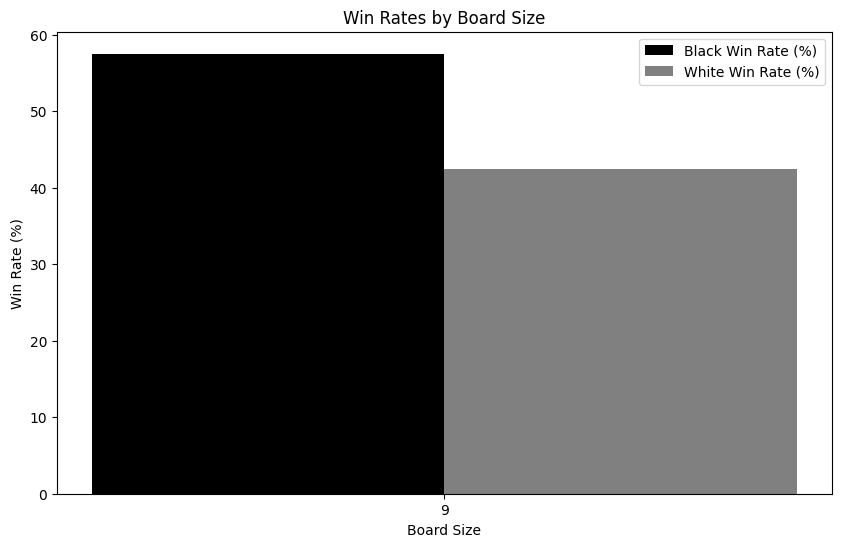

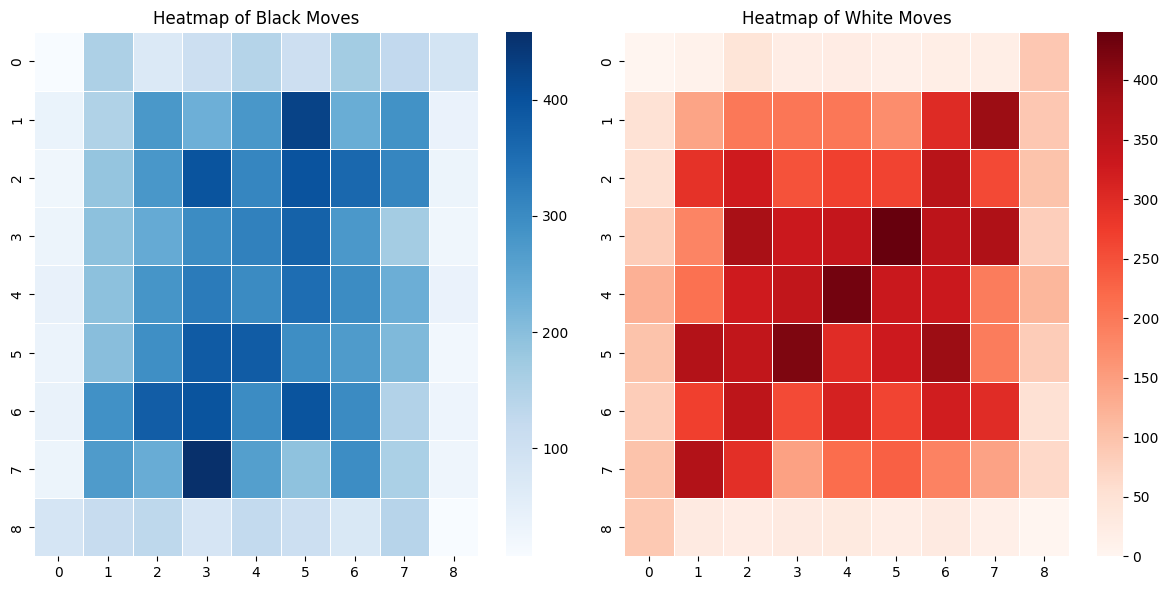

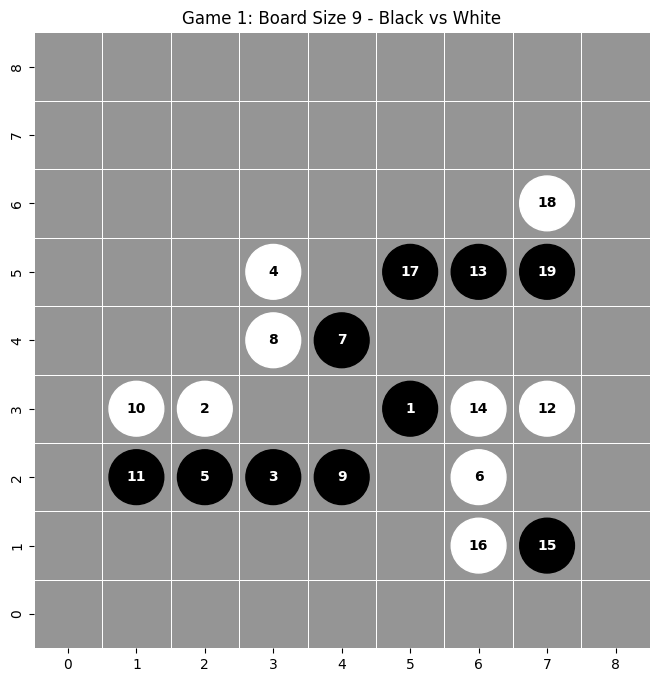

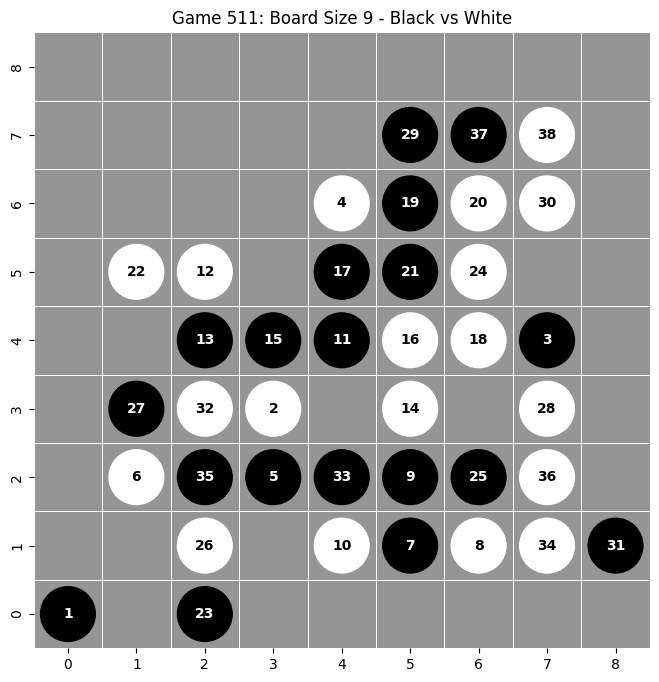

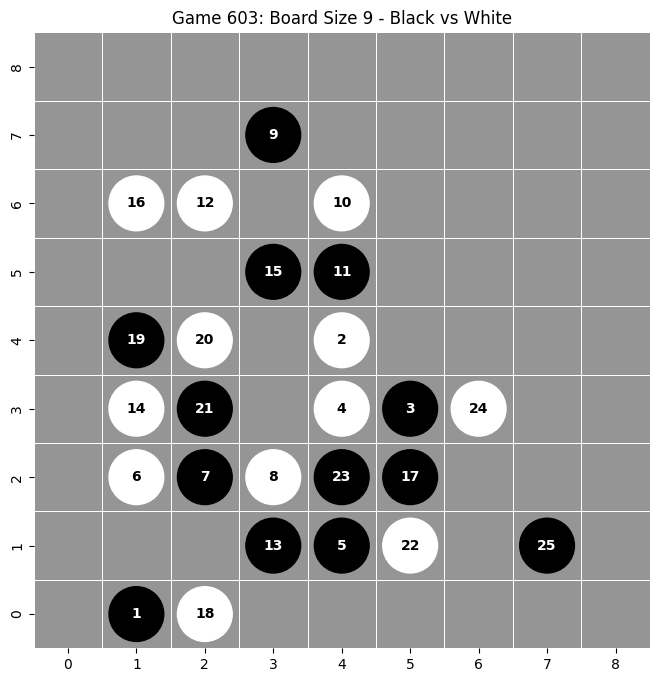

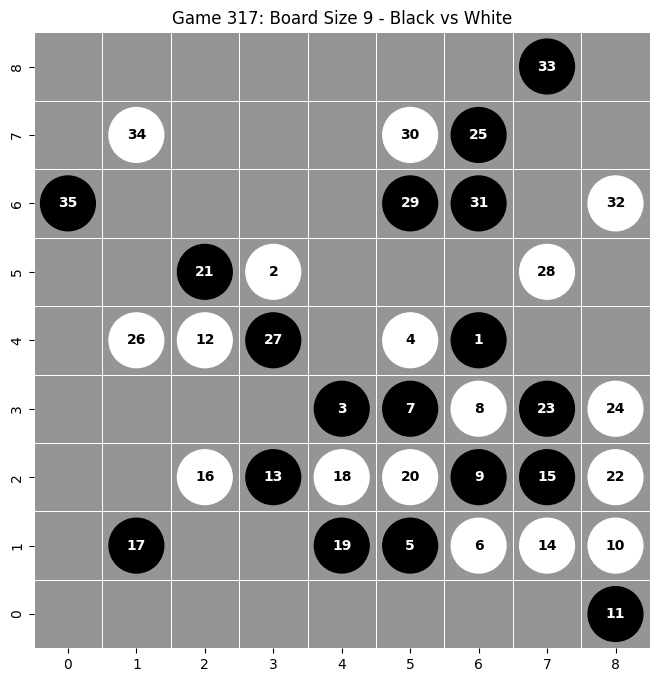

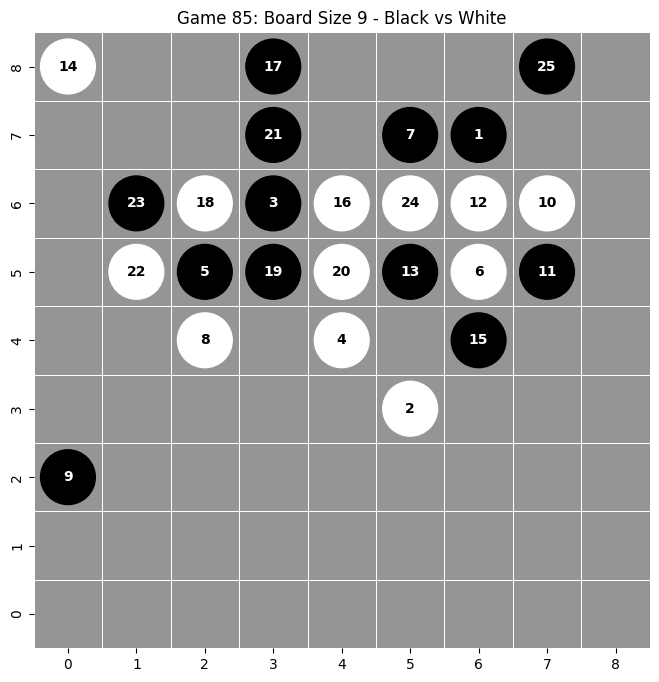

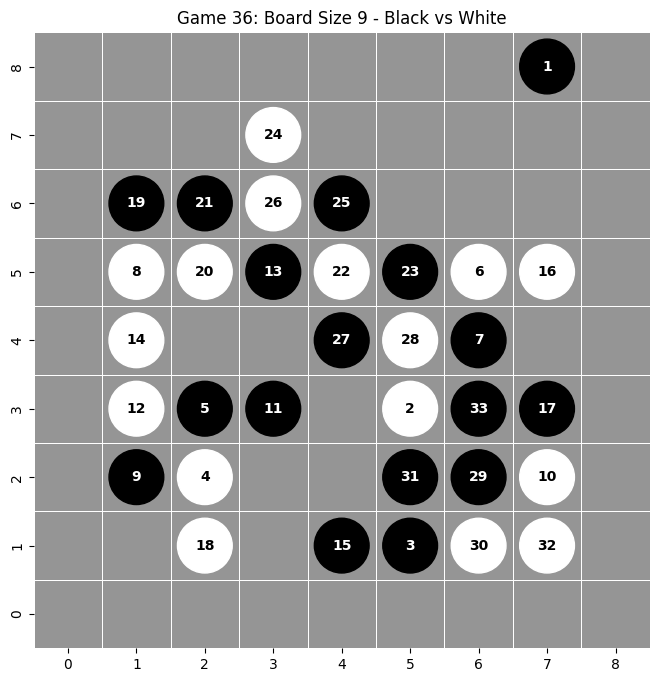

In [19]:
Visualizer.display_sgf_insights(general_insights)                                           # Visualize SGF insights (e.g., distribution, win rates, move heatmaps)
Visualizer.plot_game_board(sgf_analyzer, game_index=0)                                      # Plot a specific game board with move numbers (e.g., game 0)
Visualizer.plot_random_game_boards(sgf_analyzer, num_boards=5)                              # Plot multiple random game boards

NPZ Data Analysis:
binaryInputNCHWPacked shape: (4113, 22, 11)
policyTargetsNCMove shape: (4113, 2, 82)
valueTargetsNCHW shape: (4113, 5, 9, 9)


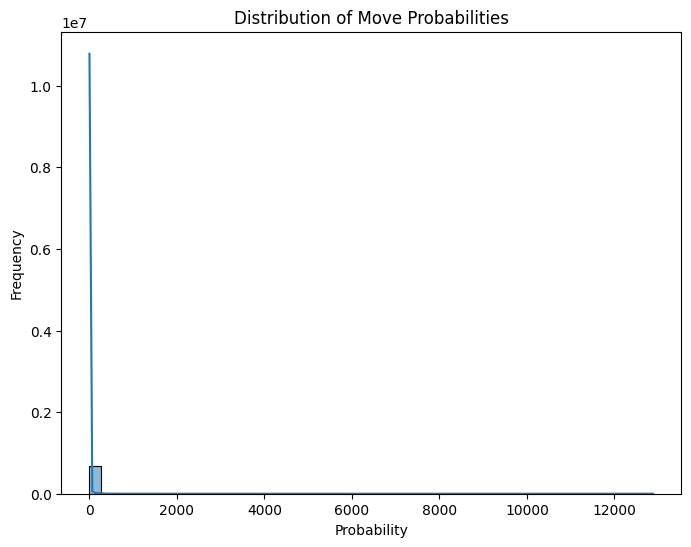

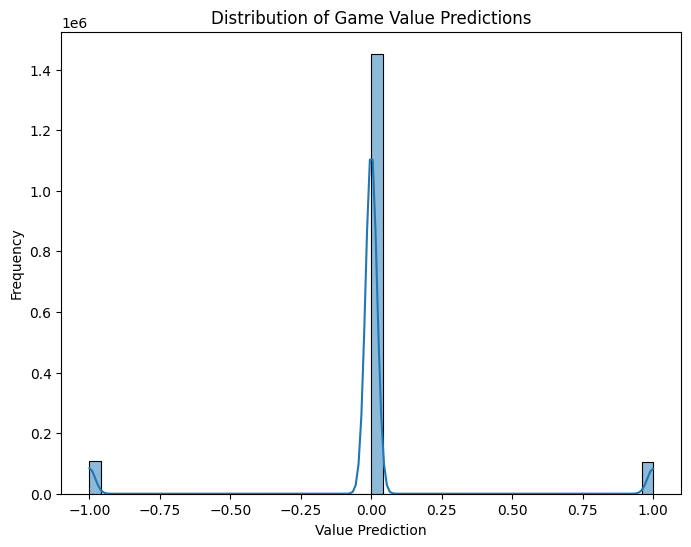

In [20]:
Visualizer.display_npz_insights(npz_analyzer)